In [1]:
import ops
from ops.imports_ipython import *
import ops.firesnake
from ops.firesnake import Snake
from ops.qc import *
import seaborn as sns
from glob import glob
from microfilm import microplot
from microfilm.microplot import Micropanel
import matplotlib.pyplot as plt
import matplotlib

# Function to generate file paths
def generate_file_paths(well, tile):
    files = []
    
    # For PH, we typically have a single multichannel image per well/tile
    files.append([preprocess_pattern.format(well=well, channel=channel, tile=tile) 
                  for channel in CHANNELS])
    
    return files

# custom function to create segmentation colormap
def random_cmap(alpha=0.5, num_colors=256):
    """Create random colormap for segmentation"""
    
    colmat = np.random.rand(num_colors,4)
    colmat[:,-1] = alpha
    colmat[0, :] = [0, 0, 0, 1]  # Set the first color to black with full transparency
    cmap = matplotlib.colors.ListedColormap(colmat)

    return cmap

# GLASBEY_INVERTED = (ops.constants.GLASBEY_INVERTED)

### Set directory and ph parameters:

In [2]:
# Set screen directories
ph_function_home = "/lab/barcheese01/screens"
ph_function_dataset = "aconcagua"
home = os.path.join(ph_function_home, ph_function_dataset)

# Change working directory to home
os.chdir(home)

# Create the directories
os.makedirs(os.path.join(home, 'ph_2/tif'), exist_ok=True)
os.makedirs(os.path.join(home, 'ph_2/csv'), exist_ok=True)

The following cell contains crucial variables that need to be set according to your specific experimental setup and data organization. Please review and modify these variables as needed before proceeding with the analysis.

- `WELLS` and `TILES`: The well and tile you want to analyze (for this notebook, we're using one well/tile combination for testing)
- `CHANNELS` and `preprocess_pattern`: The channel names and file naming conventions
- `DISPLAY_RANGES` and `LUTS`: The display ranges and color schemes (Look-Up Tables) for your image data

Ensure these variables accurately reflect your experimental setup to guarantee correct data processing and analysis.

In [3]:
# Set wells and tiles (in this notebook, one well / tile combination to test on)
WELLS = 'A1'
TILES = 186 
WILDCARDS = dict(well=WELLS, tile=TILES)

# Define channels
CHANNELS = ['DAPI_1x1-GFP_1x1', 'A594_1x1', 'AF750_1x1']

# Define the file pattern
preprocess_pattern = 'input_ph_tif/20X_{well}_Tile-{tile}.phenotype.Channel-{channel}.tif'

# Microplot information
DISPLAY_RANGES = [
    [500, 20000],
    [800, 5000],
    [800, 5000],
    [800, 5000]
]

# Define LUTs (Lookup Tables) for different channels
LUTS = [
    ops.io.GRAY,    # Lookup table for DAPI channel
    ops.io.GREEN,   # Lookup table for CY3 channel
    ops.io.RED,     # Lookup table for A594 channel
    ops.io.MAGENTA, # Lookup table for CY5 channel
    ops.io.CYAN     # Lookup table for CY7 channel
]

In [4]:
input_files = generate_file_paths(WELLS, TILES)
all_files = [item for sublist in input_files for item in sublist]

# Print the files
for f in all_files:
    print(f)
    
description = parse(all_files[0])
description.pop('tag')
description

input_ph_tif/20X_A1_Tile-186.phenotype.Channel-DAPI_1x1-GFP_1x1.tif
input_ph_tif/20X_A1_Tile-186.phenotype.Channel-A594_1x1.tif
input_ph_tif/20X_A1_Tile-186.phenotype.Channel-AF750_1x1.tif


{'subdir': 'input_ph_tif',
 'mag': '20X',
 'well': 'A1',
 'tile': '186',
 'ext': 'tif',
 'file': 'input_ph_tif/20X_A1_Tile-186.phenotype.Channel-DAPI_1x1-GFP_1x1.tif'}

##### load files

In [5]:
input_images = [read(f) for f in all_files]
print(len(input_images))

3


##### apply illumination correction

In [6]:
# Read the illumination correction files
icf_files = [f'illumination_correction/20X_{WELLS}.phenotype.Channel-{channel}.illumination_correction.tif' for channel in CHANNELS]
corrections = [read(os.path.join(home, icf)) for icf in icf_files]

# This corresponds to the 'apply_illumination_correction' rule in Snakemake
illumination_corrected_images = []
for img, correction in zip(input_images, corrections):
    corrected = Snake._apply_illumination_correction(img, correction=correction)
    illumination_corrected_images.append(corrected)

##### align

In [7]:
# This corresponds to the 'align' rule in Snakemake
stacked = Snake._stack_channels(illumination_corrected_images)
aligned = Snake._align_phenotype_channels(stacked, target=0, source=2, riders = [3])
print(aligned.shape)
save(name(description, tag='aligned', subdir='ph_2/tif'), aligned, display_ranges=DISPLAY_RANGES, luts=LUTS) # play around with display ranges

(4, 2960, 2960)


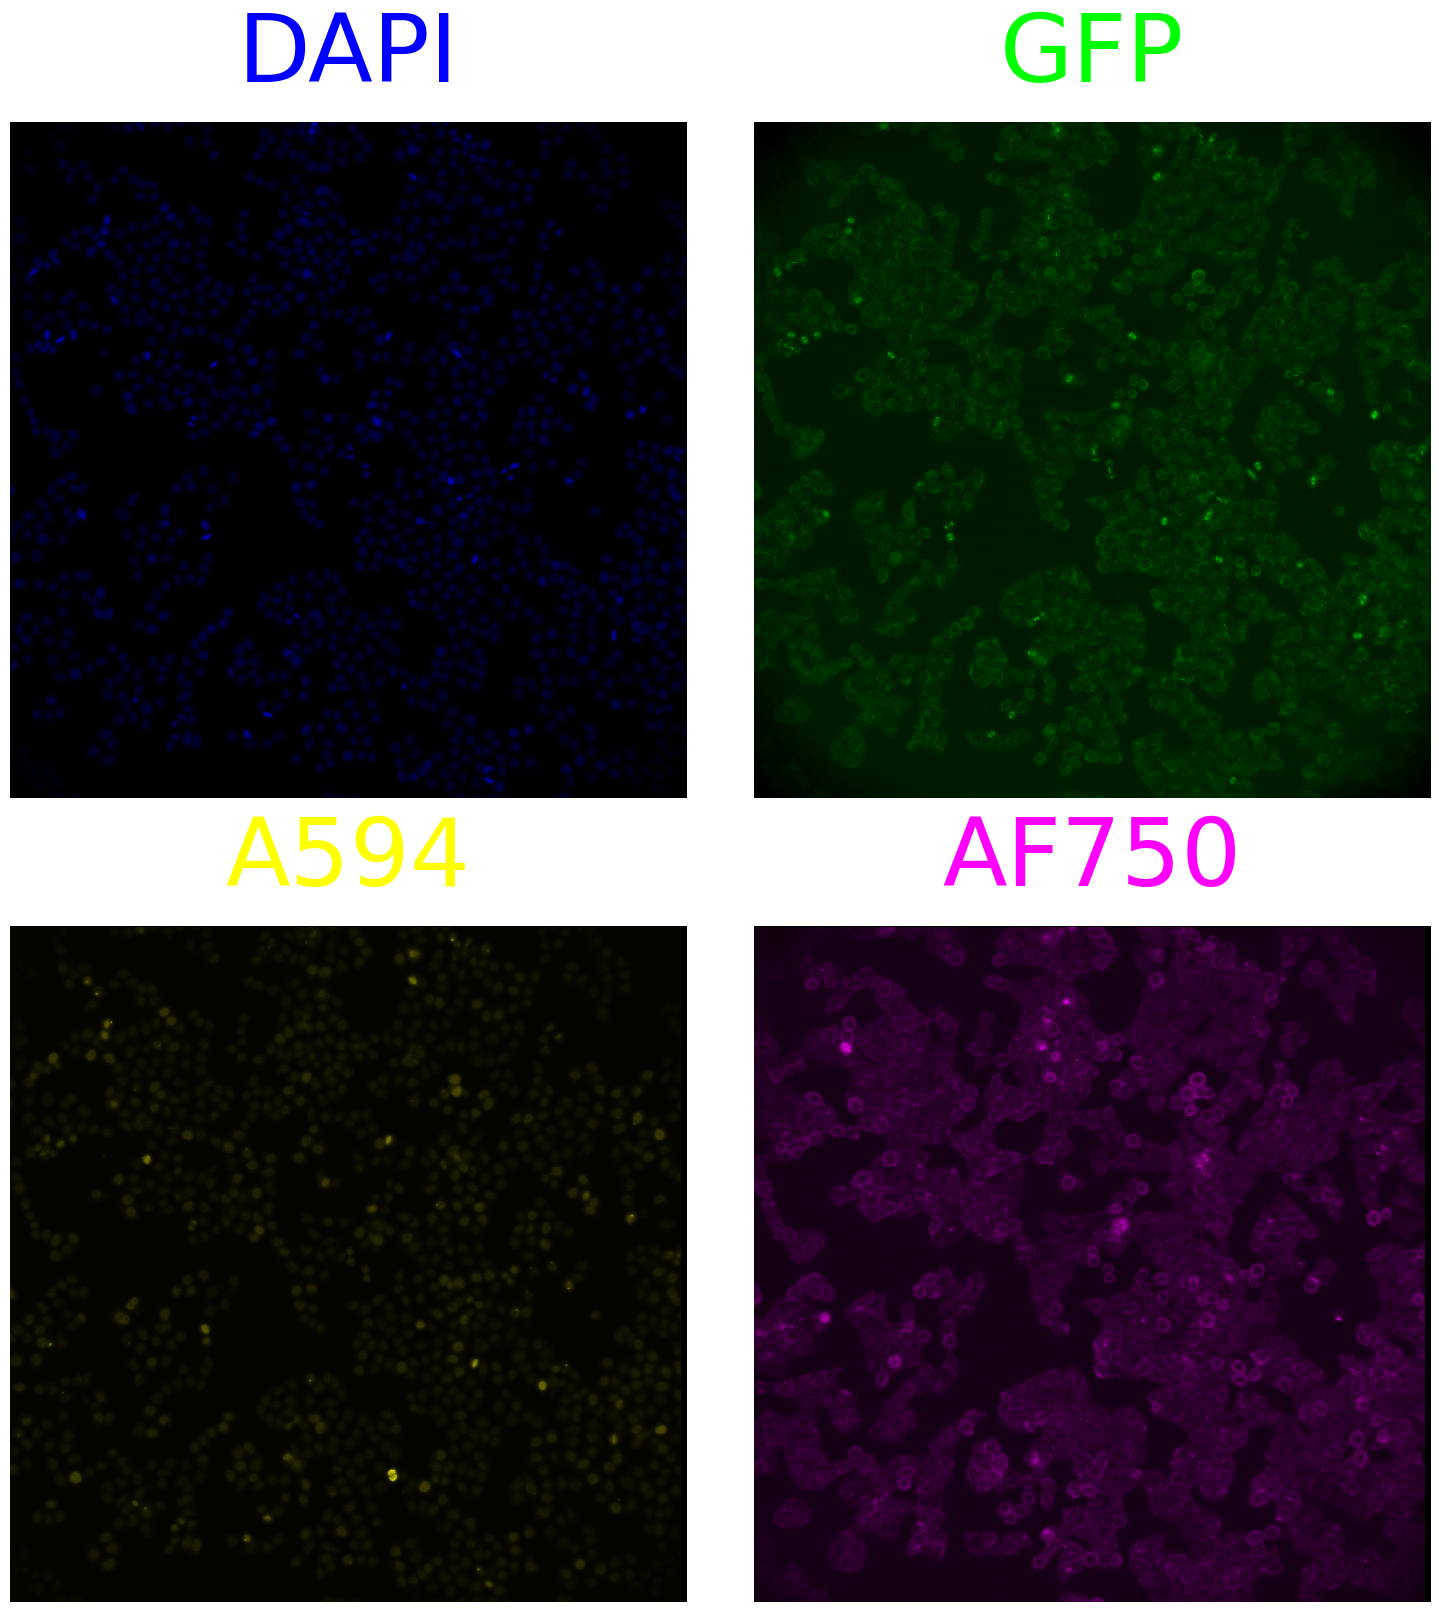

In [8]:
# show aligned
ph0_aligned_microshow = microplot.Microimage(aligned[0,:,:],
                                             cmaps = 'pure_blue',
                                             channel_names='DAPI')
ph1_aligned_microshow = microplot.Microimage(aligned[1,:,:],
                                             cmaps = 'pure_green',
                                             channel_names='GFP')
ph2_aligned_microshow = microplot.Microimage(aligned[2,:,:],
                                             cmaps = 'pure_yellow',
                                             channel_names='A594')
ph3_aligned_microshow = microplot.Microimage(aligned[3,:,:],
                                             cmaps = 'pure_magenta',
                                             channel_names='AF750')
panel = Micropanel(rows=2, cols=2, figscaling=8)
panel.add_element([0,0], ph0_aligned_microshow)
panel.add_element([0,1], ph1_aligned_microshow)
panel.add_element([1,0], ph2_aligned_microshow)
panel.add_element([1,1], ph3_aligned_microshow)
panel.add_channel_label()

The following cell contains important variables for preparing the image for Cellpose segmentation. Please review and adjust these variables based on your specific experimental setup before proceeding with the analysis.

- `DAPI_INDEX`: The index of the DAPI channel in your phenotyping image stack (0-indexed). Typically 0 for the DAPI channel.
- `CYTO_CHANNEL`: The index of the cytoplasmic channel in your phenotyping image stack (0-indexed). Typically the channel that best outlines cell boundaries, such as a membrane stain.

Ensure these variables accurately reflect the channel organization in your experimental phenotyping data to guarantee effective Cellpose segmentation.

In [9]:
# Define Cellpose segmentation parameters
DAPI_INDEX = 0 
CYTO_CHANNEL = 3

In [10]:
# Generate a file for testing Cellpose (this is wrapped into segmentation, and is not run in snakemake)
cellpose_rgb = Snake._prepare_cellpose(aligned, DAPI_INDEX, CYTO_CHANNEL)
print(cellpose_rgb.shape)
save(name(description, tag='prepared_cellpose', subdir='ph_2/tif'), cellpose_rgb)

/lab/barcheese01/mdiberna/OpticalPooledScreens/venv_ops_new/lib/python3.8/site-packages/skimage/util/dtype.py:531: UserWarning: Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)


(3, 2960, 2960)


##### segment nuclei, cells, cytoplasm

There are three segmentation methods available:

1. **Cellpose method** (recommended):
   - Uses machine learning-based segmentation
   - Parameters: `NUCLEI_DIAMETER`, `CELL_DIAMETER`, `CYTO_MODEL`

2. **cell_2022 method**:
   - Uses adaptive thresholding and improved cell boundary detection
   - Parameters: `BACKGROUND_THRESHOLD_OFFSET`, `BACKGROUND_QUANTILE`, `CELL_COUNT_THRESHOLDS`, `BACKGROUND_EROSION`, `BACKGROUND_SMOOTH`

3. **cell_2019 method**: 
   - Uses simple thresholding and area constraints
   - Parameters: `THRESHOLD_DAPI`, `THRESHOLD_CELL`, `NUCLEUS_AREA`

Choose the appropriate method by setting the `SEGMENT_METHOD` variable to either "cellpose", "cell_2022", or "cell_2019".

Please review and adjust the segmentation parameters based on your calibration results and specific experimental setup before proceeding with the analysis.

For Cellpose segmentation, we strongly suggest calibrating via the Cellpose GUI. Follow these steps:

1. Open a terminal window
2. SSH onto fry: `ssh -Y your_username@fry.wi.mit.edu`
3. Activate a conda environment with cellpose[gui]: `conda activate ops_viewing`
4. Launch Cellpose: `python -m cellpose`
5. Open the prepared Cellpose image: `ph_2/tif/20X_well_Tile-nn.prepared_cellpose.tif`
6. Calibrate cyto3 model:
   - For cell diameter: use chan to segment = 2, chan2 = 3
   - For nuclei diameter: use chan to segment = 3, chan2 = 0

Note: You may want to adjust the diameter parameters and segment to test if you feel like you are capturing too little or too much area for either of the two masks.

In [21]:
# Define segmentation parameters
SEGMENT_METHOD = "cellpose"  # Options: "cellpose", "cell_2022", or "cell_2019"

# Parameters for cellpose method
NUCLEI_DIAMETER = 42.4  # User-specific: Calculated by running Cellpose calibration
CELL_DIAMETER = 74  # User-specific: Calculated by running Cellpose calibration
CYTO_MODEL = "cyto3"  # Cellpose model to use

# Parameters for cell_2022 method
BACKGROUND_CHANNEL = 3  # Index of channel used for cell boundary detection
BACKGROUND_THRESHOLD_OFFSET = 80  # Offset added to background intensity for thresholding
BACKGROUND_QUANTILE = {'low': 0.05, 'mid': 0.025, 'high': 0.01}  # Quantiles for adaptive thresholding
CELL_COUNT_THRESHOLDS = (1400, 2500)  # Min and max expected cell counts for quality control
BACKGROUND_EROSION = 50  # Pixels to erode from background mask
BACKGROUND_SMOOTH = 3  # Gaussian smoothing sigma for background

# Parameters for cell_2019 method 
THRESHOLD_DAPI = 2500  # Threshold for segmenting nuclei based on DAPI signal
THRESHOLD_CELL = 500  # Threshold for segmenting cells on phenotype background signal
NUCLEUS_AREA = (250, 3500)  # Min and max nucleus area

In [22]:
# This corresponds to the 'segment' rule in Snakemake
if SEGMENT_METHOD == "cellpose":
    data = aligned
    print(data.shape)    
    nuclei, cells = Snake._segment_cellpose(
        data=aligned,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_CHANNEL,
        nuclei_diameter=NUCLEI_DIAMETER,
        cell_diameter=CELL_DIAMETER,
        cyto_model=CYTO_MODEL
    )
elif SEGMENT_METHOD == "cell_2022":
    data = aligned
    print(data.shape)    
    nuclei, cells = Snake._segment_cell_2022(
        data=aligned,
        nuclei_threshold=THRESHOLD_DAPI,
        nuclei_area_min=NUCLEUS_AREA[0],
        nuclei_area_max=NUCLEUS_AREA[1],
        channel=BACKGROUND_CHANNEL,
        background_offset=BACKGROUND_THRESHOLD_OFFSET,
        cell_count_thresholds=CELL_COUNT_THRESHOLDS,
        background_quantile=BACKGROUND_QUANTILE,
        smooth=BACKGROUND_SMOOTH,
        erosion=BACKGROUND_EROSION
    )
elif SEGMENT_METHOD == "cell_2019":
    data = aligned
    print(data.shape)    
    nuclei, cells = Snake._segment_cell_2019(
        data=aligned,
        nuclei_threshold=THRESHOLD_DAPI,
        nuclei_area_min=NUCLEUS_AREA[0],
        nuclei_area_max=NUCLEUS_AREA[1],
        cell_threshold=THRESHOLD_CELL
    )

else:
    raise ValueError(f"Invalid SEGMENT_METHOD: {SEGMENT_METHOD}. Choose 'cellpose', 'cell_2022', or 'cell_2019'.")

save(name(description, tag='nuclei', subdir='ph_2/tif'), nuclei, compress=1)
save(name(description, tag='cells', subdir='ph_2/tif'), cells, compress=1)

(4, 2960, 2960)


/lab/barcheese01/mdiberna/OpticalPooledScreens/venv_ops_new/lib/python3.8/site-packages/skimage/util/dtype.py:531: UserWarning: Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)
found 1215 nuclei before removing edges
found 1171 cells before removing edges


removing edges


found 1167 nuclei before reconciling
found 1144 cells before reconciling


reconciling masks with method how=consensus


found 1114 nuclei/cells after reconciling


Number of nuclei segmented: 1114
Number of cells segmented: 1114


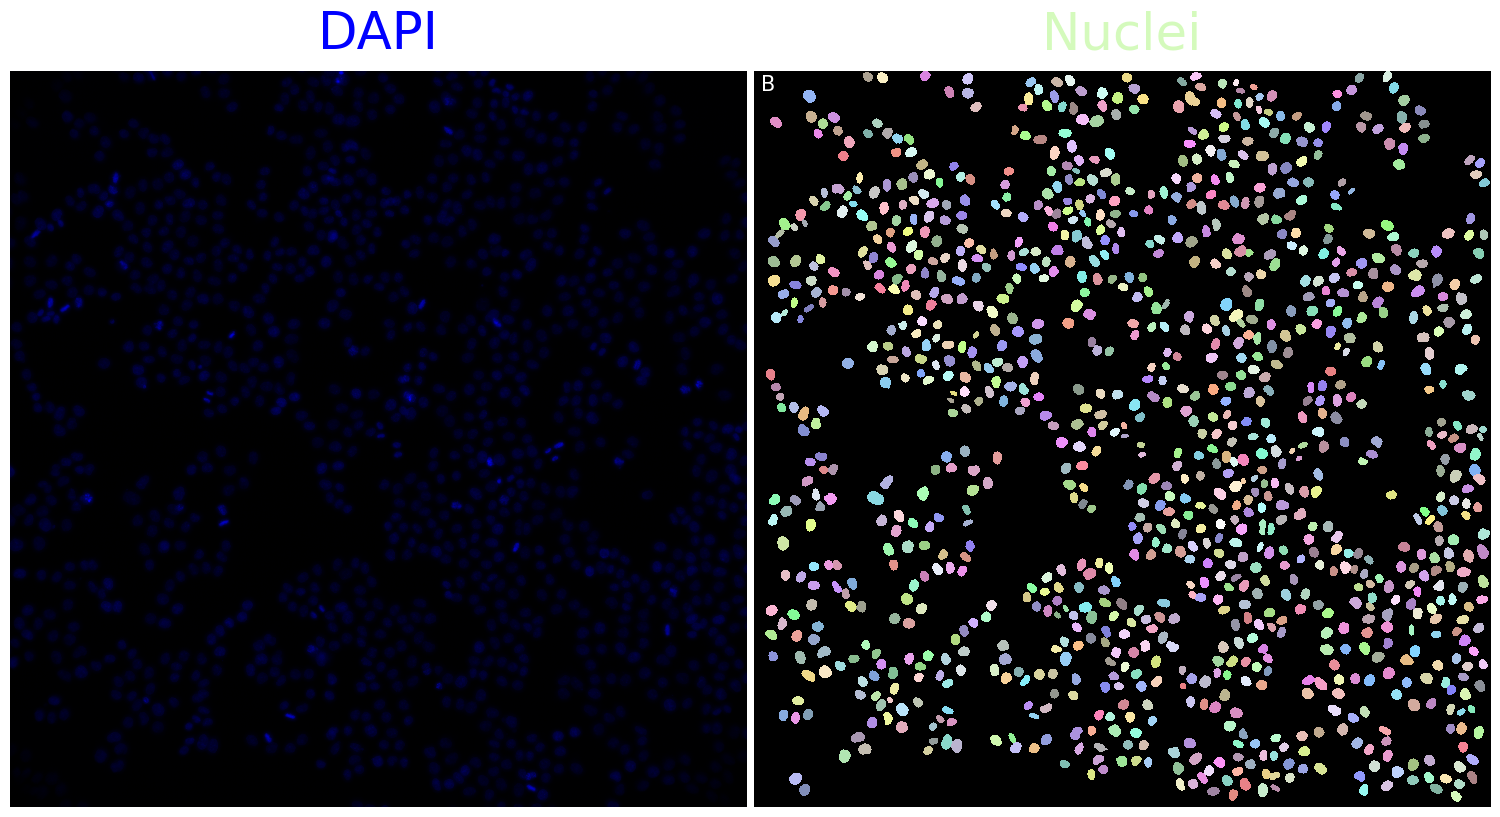

In [23]:
# Create microshow plots for each channel with specified colormaps and display ranges
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_microshow = microplot.Microimage(nuclei, 
                                        label_text='B',
                                        cmaps = nuclei_cmap,
                                        channel_names='Nuclei')

panel = Micropanel(rows=1, cols=2, figscaling=8)
panel.add_element([0,0], ph0_aligned_microshow);
panel.add_element([0,1], nuclei_microshow);
panel.add_channel_label()

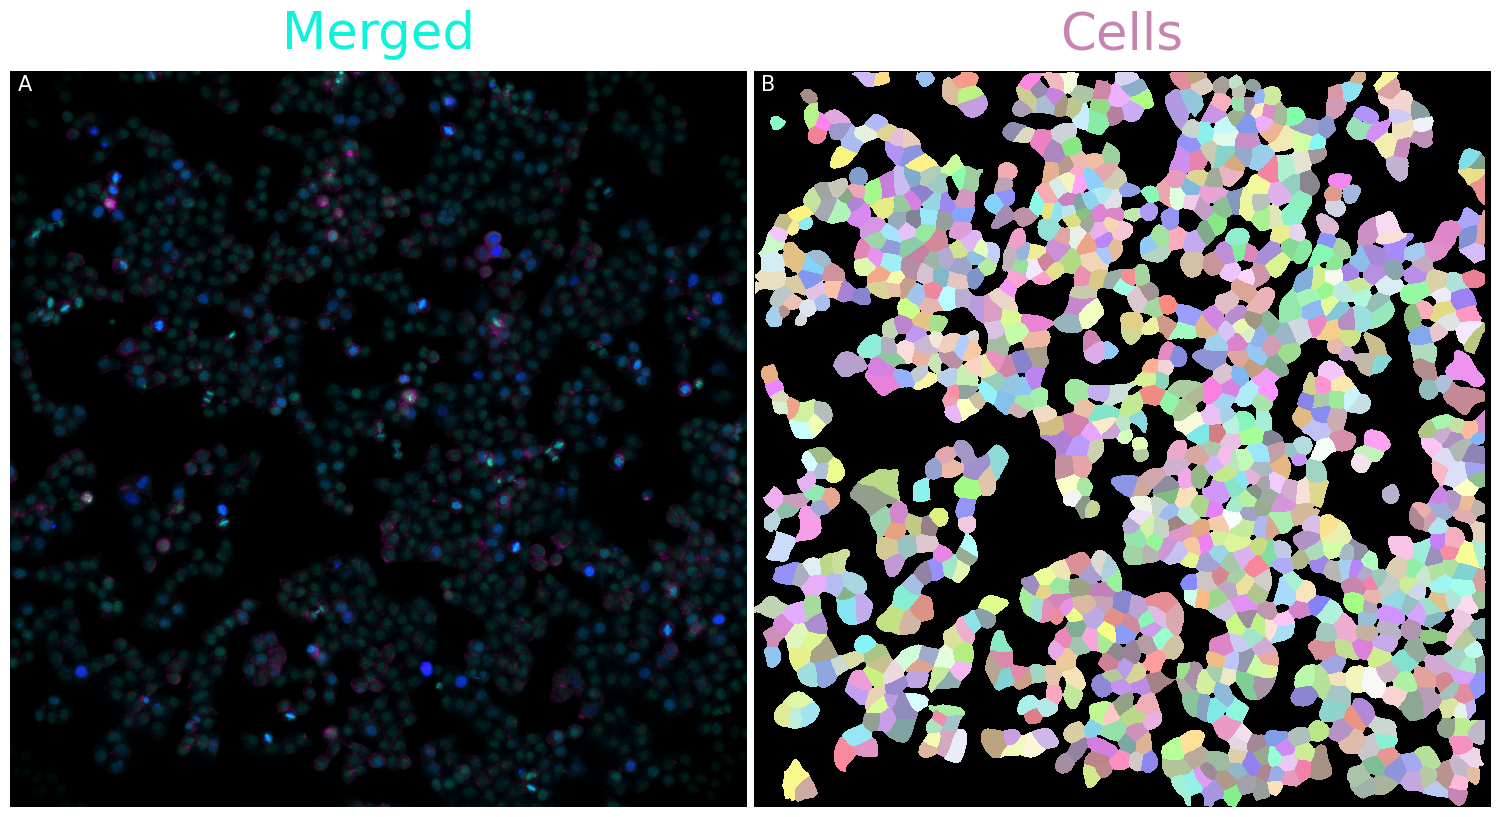

In [24]:
# Create microshow plots for each channel with specified colormaps and display ranges
all_microshow = microplot.Microimage(aligned,
                                     rescale_type='limits', 
                                     limits=DISPLAY_RANGES,
                                     label_text='A',
                                     channel_names='Merged')

cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_microshow = microplot.Microimage(cells,
                                       label_text='B',
                                       cmaps = cells_cmap,
                                       channel_names='Cells')

panel = Micropanel(rows=1, cols=2, figscaling=8)
panel.add_element([0,0], all_microshow);
panel.add_element([0,1], cells_microshow);
panel.add_channel_label()

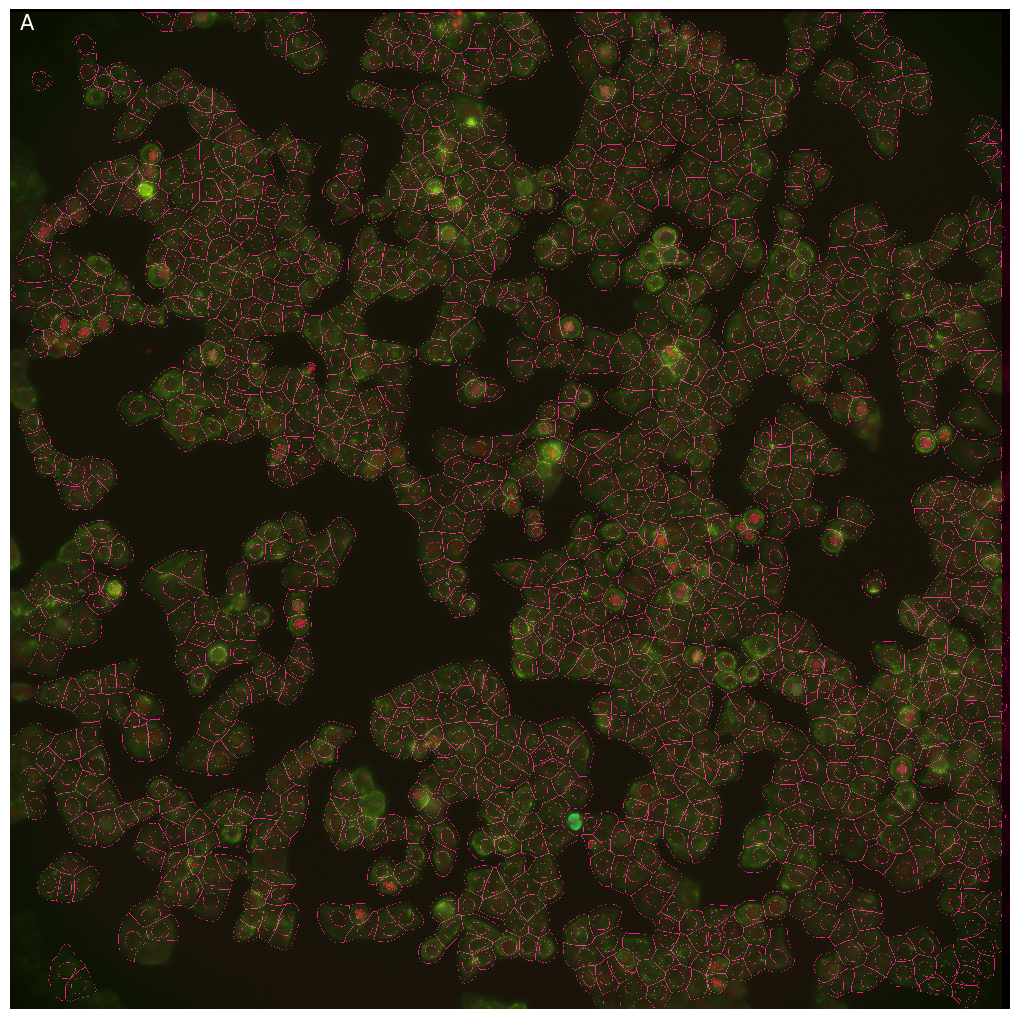

In [25]:
# Create microshow from annotated data
annotated_data=Snake._annotate_on_phenotyping_data(aligned, nuclei, cells)
save(name(description, tag='segmentation', subdir='ph_2/tif'), annotated_data)
annotated_microshow = microplot.Microimage(annotated_data,
                                           label_text='A',
                                           channel_names='Merged')
panel = Micropanel(rows=1, cols=1, figscaling=10)
panel.add_element([0,0], annotated_microshow);

In [26]:
# This corresponds to the 'segment_cytoplasm' rule in Snakemake
if SEGMENT_METHOD == "cellpose":
    cytoplasms = Snake._identify_cytoplasm_cellpose(nuclei, cells)
elif SEGMENT_METHOD in ["cell_2019", "cell_2022"]:
    cytoplasms = Snake._identify_cytoplasm(nuclei, cells)
else:
    raise ValueError(f"Invalid SEGMENT_METHOD: {SEGMENT_METHOD}. Choose 'cellpose', 'cell_2022', or 'cell_2019'.")

Number of cytoplasms identified: 1114


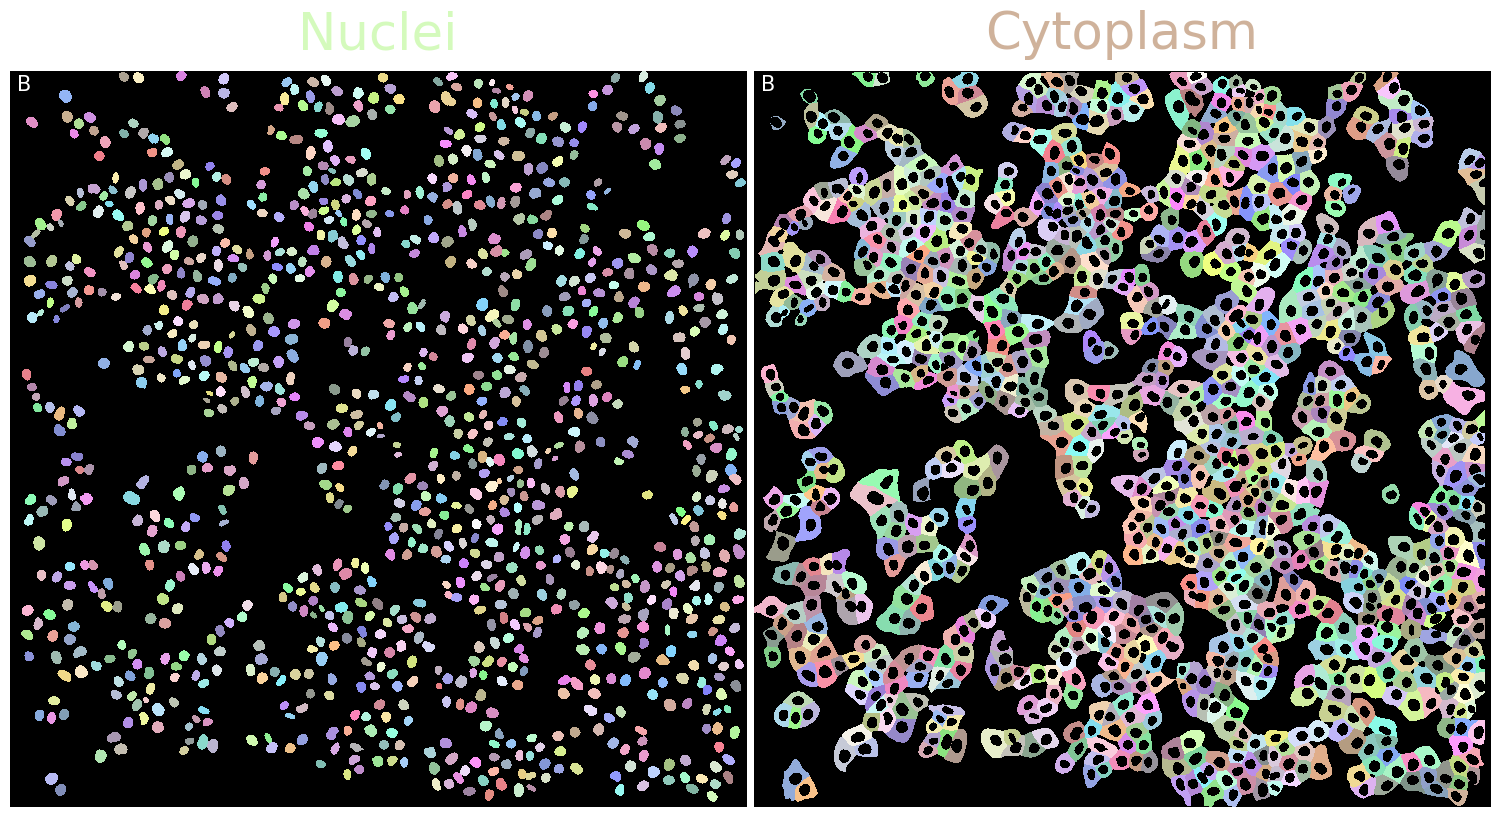

In [27]:
# Create microshow plots for cytoplasms relative to nuclei
cytoplasm_cmap = random_cmap(num_colors=len(np.unique(cytoplasms)))
cytoplasm_microshow = microplot.Microimage(cytoplasms,
                                           label_text='B',
                                           cmaps = cytoplasm_cmap,
                                           channel_names='Cytoplasm')
panel = Micropanel(rows=1, cols=2, figscaling=8)
panel.add_element([0,0], nuclei_microshow);
panel.add_element([0,1], cytoplasm_microshow);
panel.add_channel_label()

##### extract phenotype information

In [28]:
# This corresponds to the 'phenotype_info' rule in Snakemake
df_ph_info = Snake._extract_phenotype_minimal(data_phenotype=nuclei, nuclei=nuclei, wildcards=WILDCARDS)
df_ph_info.to_csv(name(description, tag='ph_info', ext='csv', subdir='ph_2/csv'), index=None)
df_ph_info

area            i            j  cell                    bounds  tile  \
0     1265    26.241107  2542.978656     1       (2, 2525, 49, 2563)   186   
1     1334    23.965517   686.969265     2         (4, 666, 45, 709)   186   
2     1260    27.302381   456.485714     3         (8, 435, 48, 477)   186   
3     1529    31.005886   515.863963     4        (10, 494, 54, 539)   186   
4     1191    25.762385  1774.281276     5      (10, 1752, 43, 1798)   186   
...    ...          ...          ...   ...                       ...   ...   
1109  1533  2885.689498  2740.361383  1110  (2866, 2716, 2906, 2767)   186   
1110   713  2882.983170  2092.863955  1111  (2869, 2074, 2898, 2112)   186   
1111  1393  2896.536971  1844.765973  1112  (2880, 1820, 2914, 1871)   186   
1112  1305  2910.109579  1923.788506  1113  (2888, 1906, 2934, 1944)   186   
1113  1400  2916.535000  2819.603571  1114  (2895, 2798, 2940, 2842)   186   

     well  
0      A1  
1      A1  
2      A1  
3      A1  
4      A1  
...   ...  
1109   A1  
1110   A1  
1111   A1  
1112   A1  
1113   A1  

[1114 rows x 7 columns]

The following cell contains important variables for feature extraction from the phenotyping images. Please review and adjust these variables based on your specific experimental data before proceeding with the analysis.

- `FOCI_CHANNEL`: Determines which channel is used for foci detection. This should be set to the index of the channel containing the marker you want to detect foci for.
- `CHANNEL_NAMES`: A list of names for each channel in your phenotyping image. These names will be used in the output data frame to label the features extracted from each channel.

Ensure these variables accurately reflect the channel organization and content in your experimental data to guarantee effective feature extraction.

In [29]:
# Define cellpose parameters
FOCI_CHANNEL = 2
CHANNEL_NAMES = ['dapi','tubulin','gh2ax','phalloidin']

In [30]:
# This corresponds to the 'extract_phenotype_cp' rule in Snakemake
df_ph = Snake._extract_phenotype_cp_multichannel(data_phenotype=aligned, nuclei=nuclei, cells=cells, wildcards=WILDCARDS, cytoplasms=cytoplasms, foci_channel=FOCI_CHANNEL, channel_names=CHANNEL_NAMES)
df_ph.to_csv(name(description, tag='phenotype', ext='csv', subdir='ph_2/csv'), index=None)
df_ph

/lab/barcheese01/mdiberna/OpticalPooledScreens/ops/process.py:933: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(


label  nucleus_dapi_int  nucleus_tubulin_int  nucleus_gh2ax_int  \
0         1           2400844              1013325             853248   
1         2           3257844              1236503            1245439   
2         3           2545009               913209             892624   
3         4           5353017              1230693            1594563   
4         5           3733224              1263263            1397461   
...     ...               ...                  ...                ...   
1109   1110           2339139               990360            1046689   
1110   1111           7558943              1272331            2488337   
1111   1112           3815071              1531921            1330198   
1112   1113           3846062              1489635            1431520   
1113   1114           1627278               705111             827581   

      nucleus_phalloidin_int  nucleus_dapi_mean  nucleus_tubulin_mean  \
0                     778193        1897.900395            801.047431   
1                     943650        2442.161919            926.913793   
2                     681674        2019.848413            724.769048   
3                     938130        3500.992152            804.900589   
4                     999373        3134.528967           1060.674223   
...                      ...                ...                   ...   
1109                 1156083        1525.857143            646.027397   
1110                  711828       10601.603086           1784.475456   
1111                 1084619        2738.744436           1099.727925   
1112                 1158608        2947.173946           1141.482759   
1113                  684997        1162.341429            503.650714   

      nucleus_gh2ax_mean  nucleus_phalloidin_mean  nucleus_dapi_std  ...  \
0             674.504348               615.172332        239.013128  ...   
1             933.612444               707.383808        439.444633  ...   
2             708.431746               541.011111        371.198249  ...   
3            1042.879660               613.557881        721.093529  ...   
4            1173.350966               839.104114        478.296377  ...   
...                  ...                      ...               ...  ...   
1109          682.771689               754.131115        253.514186  ...   
1110         3489.953717               998.356241       3289.861877  ...   
1111          954.916009               778.620962        356.910723  ...   
1112         1096.950192               887.822222        467.255610  ...   
1113          591.129286               489.283571        187.214554  ...   

      cell_number_neighbors_1  cell_percent_touching_1  \
0                           1                 0.397759   
1                           0                 0.000000   
2                           1                 0.212418   
3                           1                 0.264228   
4                           2                 0.632411   
...                       ...                      ...   
1109                        4                 0.680851   
1110                        3                 0.588710   
1111                        5                 0.577017   
1112                        3                 0.541284   
1113                        3                 0.423567   

      cell_first_neighbor_distance  cell_second_neighbor_distance  \
0                        44.010029                     102.464208   
1                       112.575270                     163.680047   
2                        63.270187                     181.696273   
3                        63.270187                     174.155253   
4                        47.800089                      63.660573   
...                            ...                            ...   
1109                     65.806434                      72.080038   
1110                     53.237653                      57.300245   
1111                 

In [31]:
# Generate a summary of the number of cells
plot_count_heatmap(df_ph_info, shape='6W_sbs', return_plot=False, return_summary=True)

well  tile  count
0   A1   186   1114